In [73]:
# Fish Position Tracking
# Script by Dhruv Zocchi PhD, Janelia Research Campus
# Updated by Jeremy Delahanty, Hopkins Neuroscience Program Rotation Student Ahrens Lab

import cv2
import numpy as np
import pandas as pd
# Matplotlib is the classic plotting library
import matplotlib.pyplot as plt
# We use the Rectangle Patch object for annotating our distance plots
from matplotlib.patches import Rectangle
from matplotlib.widgets import RectangleSelector
from matplotlib.colors import LogNorm, Normalize

# Tkinter is a simple GUI library
from tkinter import Tk
from tkinter.filedialog import askdirectory

# Pathlib makes path manipulation a little nicer
from pathlib import Path

# h5py allows you to write to HDF5 files which are nice to use for organising
# multidimensional datasets with built in metadata/attributes
import h5py

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from typing import List, Tuple, Dict, Any, Union
import warnings

import json

# Pair Videos with Sleap Analysis Files

In [145]:
def pair_analysis_and_mp4_paths(base_path: str) -> List[Tuple[Path, Path]]:
    derivatives_path = Path(base_path) / "derivatives"
    rawdata_path = Path(base_path) / "rawdata"
    paired_paths = []

    # Iterate through all subjects in the derivatives directory
    for subject_dir in derivatives_path.glob("sub-*"):
        subject_id = subject_dir.name
        
        # Find the corresponding experiment directory in rawdata
        rawdata_subject_dir = rawdata_path / subject_id
        
        if not rawdata_subject_dir.exists():
            print(f"Warning: No rawdata directory found for {subject_id}")
            continue

        # Iterate through experiment directories in the subject's derivatives folder
        for exp_dir in subject_dir.glob("*_OnePortEtohExperiment"):
            exp_name = exp_dir.name
            
            # Find the analysis file
            analysis_file = next(exp_dir.glob("*.analysis.h5"), None)
            
            if analysis_file is None:
                print(f"Warning: No analysis file found in {exp_dir}")
                continue

            # Find the corresponding MP4 file in rawdata
            mp4_file = next(rawdata_subject_dir.glob(f"{exp_name}/*.mp4"), None)
            
            if mp4_file is None:
                print(f"Warning: No MP4 file found for {exp_name}")
                continue

            # Add the pair of paths to our list
            paired_paths.append((analysis_file, mp4_file))
            print(f"Paired: {analysis_file} with {mp4_file}")

    print(f"Found {len(paired_paths)} pairs of analysis and MP4 files.")
    return paired_paths

def get_videos_and_configs(base_directory: Path) -> List[Video]:
    # base_directory must be a pathlib Path object
    video_paths = sorted(base_directory.glob("lgfl/rawdata/*/*OnePort*/*.mp4"))
    config_paths = sorted(base_directory.glob("lgfl/rawdata/*/*OnePort*/*periment.h5"))
    sleap_paths = sorted(base_directory.glob("lgfl/derivatives/*/*OnePort*/*.analysis.h5"))
    
    video_configs = []
    for video_path in video_paths:
        print(f"Using Video: {video_path}")
        matching_config = next((cfg for cfg in config_paths if cfg.stem == video_path.stem), None)
        print(f"Using Config: {matching_config}")
        matching_sleap = next((slp for slp in sleap_paths if "analysis" in slp.stem), None)
        print(f"Using SLEAP File: {matching_sleap}")
        if matching_config is None:
            warnings.warn(f"No matching config file found for video: {video_path}")
            continue
        
        if matching_sleap is None:
            warnings.warn(f"No matching SLEAP pose file found for video: {video_path}")
        
        video_object = Video(video_path, matching_config, matching_sleap)
        video_configs.append(video_object)
    
    return video_configs

base_path = "/home/jmdelahanty/OneDrive/lgfl"
file_pairs = pair_analysis_and_mp4_paths(base_path)

# Example of how to use the returned pairs
for analysis_path, mp4_path in file_pairs:
    print(f"Analysis: {analysis_path}")
    print(f"Video: {mp4_path}")
    print("---")

configs_and_videos = get_videos_and_configs(Path(base_path))

Paired: /home/jmdelahanty/OneDrive/lgfl/derivatives/sub-0005/20240719_sub-0005_OnePortEtohExperiment/labels.v001.004_20240719_sub-0005_OnePortEtohExperiment.analysis.h5 with /home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0005/20240719_sub-0005_OnePortEtohExperiment/20240719_sub-0005_OnePortEtohExperiment.mp4
Paired: /home/jmdelahanty/OneDrive/lgfl/derivatives/sub-0021/20240722_sub-0021_OnePortEtohExperiment/labels.v001.020_20240722_sub-0021_OnePortEtohExperiment.analysis.h5 with /home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0021/20240722_sub-0021_OnePortEtohExperiment/20240722_sub-0021_OnePortEtohExperiment.mp4
Paired: /home/jmdelahanty/OneDrive/lgfl/derivatives/sub-0022/20240724_sub-0022_OnePortEtohExperiment/labels.v001.021_20240724_sub-0022_OnePortEtohExperiment.analysis.h5 with /home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0022/20240724_sub-0022_OnePortEtohExperiment/20240724_sub-0022_OnePortEtohExperiment.mp4
Paired: /home/jmdelahanty/OneDrive/lgfl/derivatives/sub-0020/20240722_sub-0020_

# Get Locations of Ports for Each Video and Analysis File

In [3]:
# From https://sleap.ai/notebooks/Analysis_examples.html
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [127]:
# Get the locations of each port (left/right ports, inlet/outlet)
def preprocess_video(video, syringe_contents):
    # pass video object
    # Set the video position to the first frame
    # We shouldn't enter this function unless the video can be opened.
    # Get the first image as the ROI selection after you're sure you've
    # gotten the frame successfully read
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    # cap.read() tells you if the frame retrieval was successful (boolean)
    # through ret, frame is the numpy array array that opencv returns
    ret, frame = video.read()

    # If the frame is returned (if ret is true)
    if ret:
        # Get the image and convert it to a numpy array shaped as an image in grayscale
        first_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # select multiple points for each port in the chamber
    points = get_points(first_image, syringe_contents)

    video.release()

    return points

def get_points(frame, syringe_contents):
    points = []
    copy = frame.copy()
    
    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            cv2.circle(copy, (x, y), 5, (0, 255, 0), -1)
            cv2.putText(copy, f"Point {len(points)}", (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            cv2.imshow(window_name, copy)
            if len(points) >= 4:
                cv2.setMouseCallback(window_name, lambda *args : None)

    # Create a descriptive window name
    window_name = f"Port Selection - Left: {syringe_contents['left']}, Right: {syringe_contents['right']}"
    
    # Setting up the callback
    cv2.imshow(window_name, copy)
    cv2.setMouseCallback(window_name, click_event)

    # Provide instructions to the user
    print("Please select points in the following order:")
    print(f"1. Left ({syringe_contents['left']}) 2. Right ({syringe_contents['right']}) 3. Inlet 4. Outlet")

    while len(points) < 4:
        cv2.waitKey(1)

    cv2.destroyAllWindows()

    # Label the points based on syringe contents
    labeled_points = {
        'Left': points[0],
        'Right': points[1],
        'Inlet': points[2],
        'Outlet': points[3],
        'H2O': points[0] if syringe_contents['left'] == 'H2O' else points[1] if syringe_contents['right'] == 'H2O' else None,
        'EtOH': points[0] if syringe_contents['left'] == 'EtOH' else points[1] if syringe_contents['right'] == 'EtOH' else None,
        'empty': points[0] if syringe_contents['left'] == 'empty' else points[1] if syringe_contents['right'] == 'empty' else None
    }

    return labeled_points
    

class Video:
    def __init__(self, video_path, config_path, sleap_path):
        self.video_path = video_path
        self.video_path_str = str(video_path)
        self.config_path = config_path
        self.sleap_path = sleap_path
        self.config_attrs = self._load_config_attrs()
        self.syringe_contents = self._determine_syringe_contents()

    def _load_config_attrs(self):
        try:
            with h5py.File(self.config_path, 'r') as h5f:
                return dict(h5f.attrs)
        except Exception as e:
            warnings.warn(f"Failed to load attributes from {self.config_path}: {str(e)}")
            return {}

    def _determine_syringe_contents(self):
        right_syringe = self.config_attrs.get('right_syringe')
        left_syringe = self.config_attrs.get('left_syringe')

        contents = {'left': 'unknown', 'right': 'unknown'}

        if right_syringe in ['EtOH', 'H2O', 'water']:
            contents['right'] = right_syringe
        if left_syringe in ['EtOH', 'H2O', 'water']:
            contents['left'] = left_syringe

        # Normalize 'water' to 'H2O'
        contents = {k: 'H2O' if v == 'water' else v for k, v in contents.items()}

        # Change 'unknown' to 'empty'
        contents = {k: 'empty' if v == 'unknown' else v for k, v in contents.items()}

        return contents

    def __repr__(self):
        return f"VideoConfig(video_path={self.video_path}, config_path={self.config_path}, syringe_contents={self.syringe_contents})"

def load_skeleton_json(file_path: Path) -> Dict[str, Any]:
    """
    Load a skeleton.json file and generate indexes for each object.

    Args:
    file_path (Path): Path to the skeleton.json file.

    Returns:
    Dict[str, Any]: A dictionary containing the parsed JSON data and generated indexes.
    """
    # Load the JSON file
    with open(file_path, 'r') as f:
        skeleton_data = json.load(f)

    # Extract node names and create indexes
    node_names = set()
    for link in skeleton_data.get('links', []):
        source = link['source']['py/state']['py/tuple'][0]
        target = link['target']['py/state']['py/tuple'][0]
        node_names.add(source)
        node_names.add(target)

    # Generate indexes for each node
    node_indexes = {f"{name}_index": i for i, name in enumerate(sorted(node_names))}

    # Add the indexes to the skeleton data
    skeleton_data['node_indexes'] = node_indexes

    return skeleton_data

def process_sleap_tracks(
    sleap_path: str, 
    skeleton_data: Dict, 
    points: Dict[str, Tuple[int, int]], 
    nodes_of_interest: List[str],
    fps: float = 30.0
) -> Dict[str, np.ndarray]:
    """
    Process SLEAP tracks, calculate metrics, and include raw tracks data.

    Args:
    sleap_path (str): Path to the SLEAP analysis file.
    skeleton_data (Dict): Skeleton data with node indexes.
    points (Dict[str, Tuple[int, int]]): Dictionary of selected points (e.g., 'Left', 'Right').
    nodes_of_interest (List[str]): List of node names to process (e.g., ['snout', 'body']).
    fps (float): Frames per second of the video.

    Returns:
    Dict[str, np.ndarray]: Dictionary of calculated metrics, points information, and raw tracks data.
    """
    # Load SLEAP tracks
    with h5py.File(sleap_path, 'r') as analysis_file:
        locations = analysis_file["tracks"][:].T
        node_names = [n.decode() for n in analysis_file["node_names"][:]]
    
    locations = fill_missing(locations)

    # Store raw tracks data
    results = {
        'node_names': node_names,
        'locations': locations,
        'points': points
    }

    # Add points information to results
    for point_name, point_coords in points.items():
        if point_coords is not None:
            results[f"point_{point_name}"] = np.array(point_coords)

    # Get node indexes
    node_indexes = {name: i for i, name in enumerate(node_names)}
    results['node_indexes'] = node_indexes

    snout_index = node_indexes['snout']
    body_index = node_indexes['body']

    snout_locations = locations[:, snout_index, :, :]
    body_locations = locations[:, body_index, :, :]

    results['snout_locations'] = snout_locations
    results['body_locations'] = body_locations

    # Calculate chamber dimensions
    left_x, _ = points['Left']
    right_x, _ = points['Right']
    chamber_width = right_x - left_x

    for node in nodes_of_interest:
        node_index = node_indexes[node]
        node_locations = locations[:, node_index, :, 0]  # Shape: (frames, 2), was [:, index, :, 0]

        # Calculate chamber position for this node
        node_x_positions = node_locations[:, 0] #was[:,0,0]
        chamber_positions = (node_x_positions - left_x) / chamber_width * 100
        results[f"{node}_chamber_position"] = chamber_positions

        # Calculate cumulative distance for this node
        cumulative_distance, frame_distances, total_distance = calculate_cumulative_distance(locations, node_index)
        results[f"{node}_cumulative_distance"] = cumulative_distance
        results[f"{node}_frame_distances"] = frame_distances
        results[f"{node}_total_distance"] = total_distance

        # Calculate velocity for this node
        vel_x, vel_y, vel_mag = calculate_velocity(locations, node_index, fps)
        results[f"{node}_velocity_x"] = vel_x
        results[f"{node}_velocity_y"] = vel_y
        results[f"{node}_velocity_mag"] = vel_mag

        for point_name, point_coords in points.items():
            if point_coords is not None:  # Check if the point exists
                # Calculate distance
                point_coords_array = np.array(point_coords)
                difference = node_locations - point_coords_array
                distance = np.linalg.norm(difference, axis=1)
                results[f"{node}_to_{point_name}_distance"] = distance

        # # Calculate orientation (angle)
        # angles = np.array([calculate_angle(body_loc, snout_loc, np.array(points['Left'])) 
        #                    for body_loc, snout_loc in zip(body_locations, snout_locations)])
        # results[f"{node}_orientation_to_Left"] = angles

    return results

def calculate_angle(point1: np.ndarray, point2: np.ndarray, reference: np.ndarray) -> float:
    """
    Calculate the angle between two vectors: (point1 -> point2) and (point1 -> reference)
    
    Args:
    point1, point2, reference: np.ndarray of shape (2,) representing 2D coordinates
    
    Returns:
    float: Angle in degrees
    """
    vector1 = point2 - point1
    vector2 = reference - point1
    
    dot_product = np.dot(vector1, vector2)
    magnitudes = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    
    cos_angle = dot_product / magnitudes
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    
    return np.degrees(angle)


def calculate_cumulative_distance(tracks: np.ndarray, node_index: int) -> tuple:
    """
    Calculate the cumulative distance and frame-by-frame distance traveled by a specific node over time.
    
    Args:
    tracks (np.ndarray): The SLEAP tracks data.
    node_index (int): The index of the node to track.
    
    Returns:
    tuple: A tuple containing:
        - np.ndarray: An array of cumulative distances for each frame.
        - np.ndarray: An array of distances traveled in each frame.
        - float: The total cumulative distance traveled.
    """
    # Extract the positions of the specified node
    node_positions = tracks[:, node_index, :, 0]  # Shape: (frames, 2)
    
    # Calculate the displacement between consecutive frames
    displacements = np.diff(node_positions, axis=0)
    
    # Calculate the distance moved in each frame
    frame_distances = np.linalg.norm(displacements, axis=1)
    
    # Calculate the cumulative sum of distances
    cumulative_distances = np.cumsum(frame_distances)
    
    # Add a zero at the beginning of cumulative_distances for the initial position
    cumulative_distances = np.insert(cumulative_distances, 0, 0)
    
    # Add a zero at the beginning of frame_distances for the initial position
    frame_distances = np.insert(frame_distances, 0, 0)
    
    # Calculate the total cumulative distance
    total_distance = cumulative_distances[-1]
    
    return cumulative_distances, frame_distances, total_distance

def smooth_diff(node_loc, win=25, poly=3, fps=30.0):
    """
    Calculate smoothed velocity using Savitzky-Golay filter.
    
    Args:
    node_loc (np.ndarray): Node locations with shape (frames, 2)
    win (int): Window size for the Savitzky-Golay filter
    poly (int): Polynomial order for the Savitzky-Golay filter
    fps (float): Frames per second of the video
    
    Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray]: x velocities, y velocities, and velocity magnitudes
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel_mag = np.linalg.norm(node_loc_vel, axis=1)

    return node_loc_vel[:, 0], node_loc_vel[:, 1], node_vel_mag

def calculate_velocity(tracks: np.ndarray, node_index: int, fps: float = 30.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate the smoothed velocity of a specific node over time for x, y, and magnitude.
    
    Args:
    tracks (np.ndarray): The SLEAP tracks data.
    node_index (int): The index of the node to track.
    fps (float): Frames per second of the video.
    
    Returns:
    Tuple[np.ndarray, np.ndarray, np.ndarray]: Arrays of smoothed x, y, and magnitude velocities for each frame.
    """
    node_positions = tracks[:, node_index, :, 0]  # Shape: (frames, 2)
    
    win = int(fps)  # 1-second window
    if win % 2 == 0:
        win += 1
    
    vel_x, vel_y, vel_mag = smooth_diff(node_positions, win=30, poly=3, fps=fps)
    
    return vel_x, vel_y, vel_mag

def process_video(video_object):
    print(f"Processing: {video_object.video_path.stem}")

    video = cv2.VideoCapture(video_object.video_path_str)
    if not video.isOpened():
        raise ValueError("Failed to open the video file.")

    # Get the frame rate of the video
    fps = video.get(cv2.CAP_PROP_FPS)

    # Get labeled points: L,R,Inlet,Outlet
    points = preprocess_video(video, video_object.syringe_contents)

    skeleton_data = load_skeleton_json("/home/jmdelahanty/ahrens_data/lgfl/oneportetoh_sleap/skeleton.json")

    # Define which nodes you're interested in
    nodes_of_interest = ['snout', 'body']

    # Process the SLEAP tracks
    results = process_sleap_tracks(video_object.sleap_path, skeleton_data, points, nodes_of_interest, fps=fps)

    # Now you can use the results for further analysis or save them
    for key, values in results.items():
        if 'distance' in key:
            if 'cumulative' in key:
                print(f"{key}:")
                print(f"  Total distance: {values[-1]:.2f}")
                print(f"  Average speed: {values[-1] / len(values):.2f} units per frame")
            else:
                print(f"{key}:")
                print(f"  Mean: {np.mean(values):.2f}")
                print(f"  Min: {np.min(values):.2f}")
                print(f"  Max: {np.max(values):.2f}")
        elif 'orientation' in key:
            print(f"{key}:")
            print(f"  Mean angle: {np.mean(values):.2f} degrees")
            print(f"  Min angle: {np.min(values):.2f} degrees")
            print(f"  Max angle: {np.max(values):.2f} degrees")
        elif 'chamber_position' in key:
            print(f"{key}:")
            print(f"  Mean position: {np.mean(values):.2f}%")
            print(f"  Min position: {np.min(values):.2f}%")
            print(f"  Max position: {np.max(values):.2f}%")

    # Save results if needed
    np.savez("out.npz", **results)
    

In [128]:
process_video(configs_and_videos[0])

Processing: 20240718_sub-0001_OnePortEtohExperiment
Please select points in the following order:
1. Left (H2O) 2. Right (empty) 3. Inlet 4. Outlet
snout_chamber_position:
  Mean position: 49.43%
  Min position: 2.04%
  Max position: 100.04%
snout_cumulative_distance:
  Total distance: 163041.47
  Average speed: 1.51 units per frame
snout_frame_distances:
  Mean: 1.51
  Min: 0.00
  Max: 65.22
snout_total_distance:
  Mean: 163041.47
  Min: 163041.47
  Max: 163041.47
snout_to_Left_distance:
  Mean: 337.04
  Min: 18.56
  Max: 637.40
snout_to_Right_distance:
  Mean: 343.37
  Min: 4.14
  Max: 625.04
snout_to_Inlet_distance:
  Mean: 211.06
  Min: 0.57
  Max: 440.57
snout_to_Outlet_distance:
  Mean: 316.13
  Min: 60.78
  Max: 441.78
snout_to_H2O_distance:
  Mean: 337.04
  Min: 18.56
  Max: 637.40
snout_to_empty_distance:
  Mean: 343.37
  Min: 4.14
  Max: 625.04
body_chamber_position:
  Mean position: 49.41%
  Min position: 1.48%
  Max position: 98.04%
body_cumulative_distance:
  Total distance

# Plotting Functions

In [6]:
configs_and_videos = get_videos_and_configs(Path("/home/jmdelahanty/OneDrive/"))

Using Video: /home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0001/20240718_sub-0001_OnePortEtohExperiment/20240718_sub-0001_OnePortEtohExperiment.mp4
Using Config: /home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0001/20240718_sub-0001_OnePortEtohExperiment/20240718_sub-0001_OnePortEtohExperiment.h5
Using SLEAP File: /home/jmdelahanty/OneDrive/lgfl/derivatives/sub-0001/20240718_sub-0001_OnePortEtohExperiment/labels.v001.000_20240718_sub-0001_OnePortEtohExperiment.analysis.h5
Using Video: /home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0002/20240718_sub-0002_OnePortEtohExperiment/20240718_sub-0002_OnePortEtohExperiment.mp4
Using Config: /home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0002/20240718_sub-0002_OnePortEtohExperiment/20240718_sub-0002_OnePortEtohExperiment.h5
Using SLEAP File: /home/jmdelahanty/OneDrive/lgfl/derivatives/sub-0001/20240718_sub-0001_OnePortEtohExperiment/labels.v001.000_20240718_sub-0001_OnePortEtohExperiment.analysis.h5
Using Video: /home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0

In [141]:
def plot_track_and_heatmap(location_data, points):

    # Ensure location_data is a numpy array
    if isinstance(location_data, list):
        location_data = np.array(location_data)
    
    # Check if location_data is 1D or 2D
    if location_data.ndim == 1:
        # If 1D, reshape to 2D
        location_data = location_data.reshape(-1, 2)
    elif location_data.ndim > 2:
        raise ValueError(f"location_data has {location_data.ndim} dimensions, expected 1 or 2")
    
    # Create the plot with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot snout path on the first subplot
    ax1.plot(location_data[:, 0], location_data[:, 1], 'b-', alpha=0.5, label='Snout Path')
    ax1.scatter(location_data[0, 0], location_data[0, 1], color='green', s=100, label='Start')
    ax1.scatter(location_data[-1, 0], location_data[-1, 1], color='red', s=100, label='End')
    
    # Plot chamber points on the first subplot
    chamber_points = ['Left', 'Right', 'Inlet', 'Outlet', 'H2O', 'EtOH', 'empty']
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'gray']
    for point, color in zip(chamber_points, colors):
        if point in points and points[point] is not None:
            point_coords = points[point]
            print(f"Plotting {point} at coordinates {point_coords}")
            ax1.scatter(point_coords[0], point_coords[1], color=color, s=100, label=point)
        else:
            print(f"Skipping {point} as it's not in points or is None")
    
    ax1.set_title('Snout Movement Path')
    ax1.set_xlabel('X coordinate')
    ax1.set_ylabel('Y coordinate')
    ax1.legend()
    ax1.invert_yaxis()
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create heatmap on the second subplot
    heatmap, xedges, yedges = np.histogram2d(location_data[:, 0], location_data[:, 1], bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im = ax2.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
    ax2.set_title('Movement Heatmap')
    ax2.set_xlabel('X coordinate')
    ax2.set_ylabel('Y coordinate')
    ax2.invert_yaxis()
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax2)
    cbar.set_label('Frequency')
    
    # Plot chamber points on the heatmap
    for point, color in zip(chamber_points, colors):
        if point in points and points[point] is not None:
            point_coords = points[point]
            ax2.scatter(point_coords[0], point_coords[1], color=color, s=100, edgecolors='white')
    
    plt.tight_layout()
    
    # Save the plot
    output_path = 'snout_path_and_heatmap_plot.png'
    plt.savefig(output_path)
    print(f"Plot saved to {output_path}")
    
    # Show the plot
    plt.show()

def plot_total_distances(cumulative_distances: np.ndarray, frame_distances: np.ndarray, total_distance: float, output_path: Path = None):
    """
    Plot the cumulative distance and frame-by-frame distance traveled by a specific node over time.
    
    Args:
    cumulative_distances (np.ndarray): An array of cumulative distances for each frame.
    frame_distances (np.ndarray): An array of distances traveled in each frame.
    total_distance (float): The total cumulative distance traveled.
    output_path (Path, optional): Path to save the plot. If None, the plot will be displayed but not saved.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot cumulative distance
    ax1.plot(cumulative_distances, 'b-')
    ax1.set_title('Cumulative Distance Traveled')
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Distance (pixels)')
    ax1.text(0.05, 0.95, f'Total distance: {total_distance:.2f} pixels', 
             transform=ax1.transAxes, verticalalignment='top')
    ax1.grid(True)
    
    # Plot frame-by-frame distance
    ax2.plot(frame_distances, 'b-')
    ax2.set_title('Frame-by-Frame Distance')
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Distance (pixels)')
    ax2.grid(True)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
        print(f"Plot saved to {output_path}")
    else:
        plt.show()

def plot_port_distances(results: Dict[str, np.ndarray], node: str) -> None:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    distance_keys = [key for key in results.keys() if key.startswith(f"{node}_to_") and key.endswith("_distance")]
    print(f"Distance keys found: {distance_keys}")
    
    for key in distance_keys:
        distances = results[key]
        port_name = key.split('_to_')[1].split('_distance')[0]
        print(f"Plotting {key} with shape {distances.shape}")
        
        if distances.ndim != 1:
            raise ValueError(f"Expected 1D array for {key}, but got shape {distances.shape}")
        
        ax.plot(range(len(distances)), distances, label=f'Distance to {port_name}')
    
    ax.set_title(f'{node.capitalize()} Distance to Ports Over Time')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Distance (pixels)')
    ax.legend()
    ax.grid(True)
    
    output_path = f'{node}_distance_to_ports_plot.png'
    plt.savefig(output_path)
    print(f"Plot saved to {output_path}")
    
    plt.show()

def plot_velocities(results: Dict[str, np.ndarray], node: str, colorbar_scale: str = 'normalized') -> None:
    """
    Plot the x position, x and y velocities, and velocity magnitude of a specific node over time.
    Also calculates and plots mean velocities in bins of 15.
    
    Args:
    results (Dict[str, np.ndarray]): The dictionary containing the pre-computed results.
    node (str): The name of the node to plot (e.g., 'snout', 'body').
    colorbar_scale (str): The scaling method for the colorbar. Options: 'normalized', 'log', 'custom', 'default'
    
    Returns:
    None: The function displays and saves the plot.
    """
    fig = plt.figure(figsize=(15, 15))
    
    locations_key = f"{node}_locations"
    vel_x_key = f"{node}_velocity_x"
    vel_y_key = f"{node}_velocity_y"
    vel_mag_key = f"{node}_velocity_mag"
    
    required_keys = [locations_key, vel_x_key, vel_y_key, vel_mag_key]
    if not all(key in results for key in required_keys):
        raise KeyError(f"Required data for {node} not found in results")
    
    locations = results[locations_key]
    vel_x = results[vel_x_key]
    vel_y = results[vel_y_key]
    vel_mag = results[vel_mag_key]
    
    print(f"Plotting data for {node}")
    print(f"Locations shape: {locations.shape}, Velocity shapes: x={vel_x.shape}, y={vel_y.shape}, mag={vel_mag.shape}")
    
    # Plot x velocity
    ax1 = fig.add_subplot(411)
    ax1.plot(vel_x, 'r', label='x velocity')
    ax1.legend()
    ax1.set_ylabel('X Velocity (pixels/frame)')
    ax1.set_title(f'{node.capitalize()} X Velocity')
    ax1.set_xticks([])
    
    # Plot y velocity
    ax2 = fig.add_subplot(412, sharex=ax1)
    ax2.plot(vel_y, 'b', label='y velocity')
    ax2.legend()
    ax2.set_ylabel('Y Velocity (pixels/frame)')
    ax2.set_title(f'{node.capitalize()} Y Velocity')
    ax2.set_xticks([])
    
    # Plot velocity magnitude heatmap
    ax3 = fig.add_subplot(413, sharex=ax1)
    
    if colorbar_scale == 'normalized':
        norm = Normalize(vmin=0, vmax=1)
        normalized_vel_mag = (vel_mag - vel_mag.min()) / (vel_mag.max() - vel_mag.min())
        im = ax3.imshow(normalized_vel_mag[np.newaxis, :], aspect='auto', cmap='viridis', norm=norm)
    elif colorbar_scale == 'log':
        im = ax3.imshow(vel_mag[np.newaxis, :], aspect='auto', cmap='viridis', norm=LogNorm(vmin=vel_mag.min(), vmax=vel_mag.max()))
    elif colorbar_scale == 'custom':
        vmin, vmax = np.percentile(vel_mag, [5, 95])  # Use 5th and 95th percentiles as range
        im = ax3.imshow(vel_mag[np.newaxis, :], aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    else:  # default linear scale
        im = ax3.imshow(vel_mag[np.newaxis, :], aspect='auto', vmin=0, vmax=3, cmap='viridis')
    
    ax3.set_yticks([])
    ax3.set_title('Velocity Magnitude')
    ax3.set_xlabel('Frame')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax3)
    if colorbar_scale == 'normalized':
        cbar.set_label('Normalized Velocity (0-1)')
    else:
        cbar.set_label('Velocity (pixels/second)')
    
    # Calculate and plot mean velocities in bins of 15
    ax4 = fig.add_subplot(414, sharex=ax1)
    bin_size = 15
    bins = np.arange(0, len(vel_mag), bin_size)
    mean_vel_mag = [np.mean(vel_mag[i:i + bin_size]) for i in bins]
    
    ax4.plot(bins, mean_vel_mag, 'g-', label=f'Mean Velocity Mag (bin size={bin_size})')
    ax4.legend()
    ax4.set_ylabel('Mean Velocity Magnitude (pixels/frame)')
    ax4.set_title(f'Mean Velocity Magnitude in Bins of {bin_size} Frames')
    ax4.set_xlabel('Frame')
    
    plt.tight_layout()
    
    output_path = f'{node}_position_and_velocity_plot_{colorbar_scale}_scale.png'
    plt.savefig(output_path)
    print(f"Plot saved to {output_path}")
    
    plt.show()

def load_and_plot_free_swimming(file_path: Path):
    """
    Load snout coordinates from an npz file and plot them, including chamber points.
    
    Args:
    file_path (Path): Path to the npz file containing fish tracking data.
    """
    try:
        # Load the npz file with allow_pickle=True
        data = np.load(file_path, allow_pickle=True)

        # Extract the points data
        points = data['points'].item() if isinstance(data['points'], np.ndarray) else data['points']
        
        # Extract snout coordinates
        snout_locations = np.squeeze(data['snout_locations'])

        # Extract distances
        cumulative_distance = data['snout_cumulative_distance']
        frame_distances = data['snout_frame_distances']
        total_distance = data['snout_total_distance']
        
        plot_track_and_heatmap(
            snout_locations,
            points
        )

        plot_total_distances(
            cumulative_distance,
            frame_distances,
            total_distance
        )
    
        plot_port_distances(
            data,
            node='snout'
        )

        plot_velocities(
            data,Hey, sorry -- I just realized that I was supposed to give you the linux installation media -- do you still need it?
￼￼

            node='snout',
            colorbar_scale='default'
        )

    except Exception as e:
        print(f"Failed to plot {file_path}: {str(e)}")
        raise  # Re-raise the exception for debugging



Plotting Left at coordinates (0, 246)
Plotting Right at coordinates (637, 248)
Plotting Inlet at coordinates (318, 44)
Plotting Outlet at coordinates (320, 448)
Plotting H2O at coordinates (0, 246)
Skipping EtOH as it's not in points or is None
Plotting empty at coordinates (637, 248)
Plot saved to snout_path_and_heatmap_plot.png


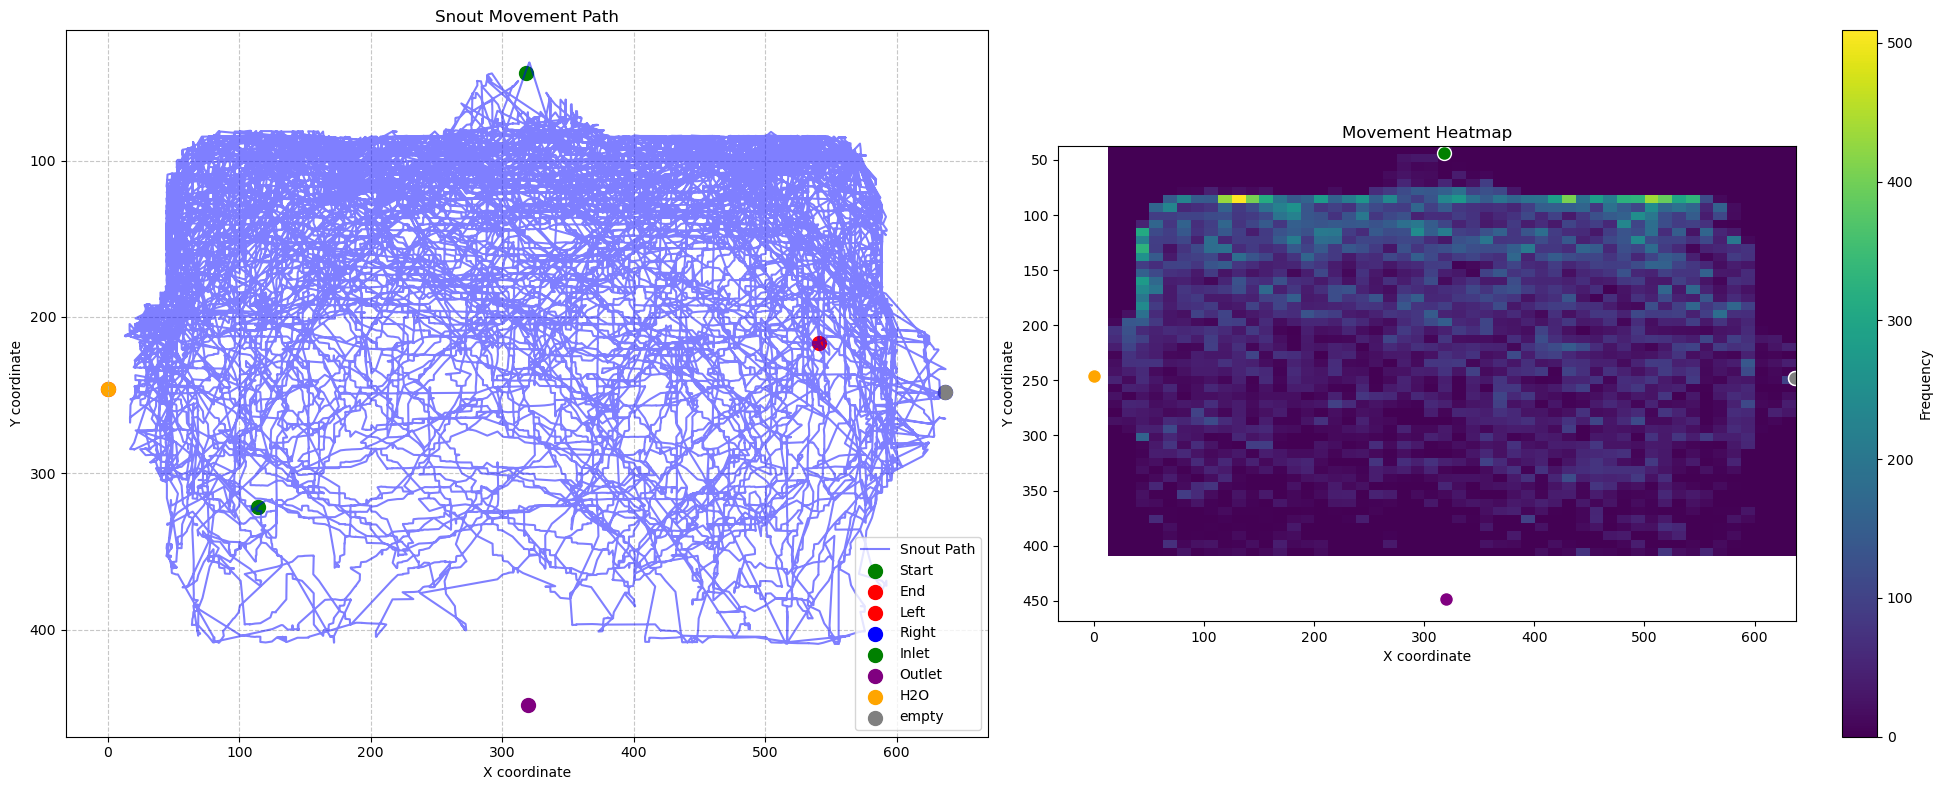

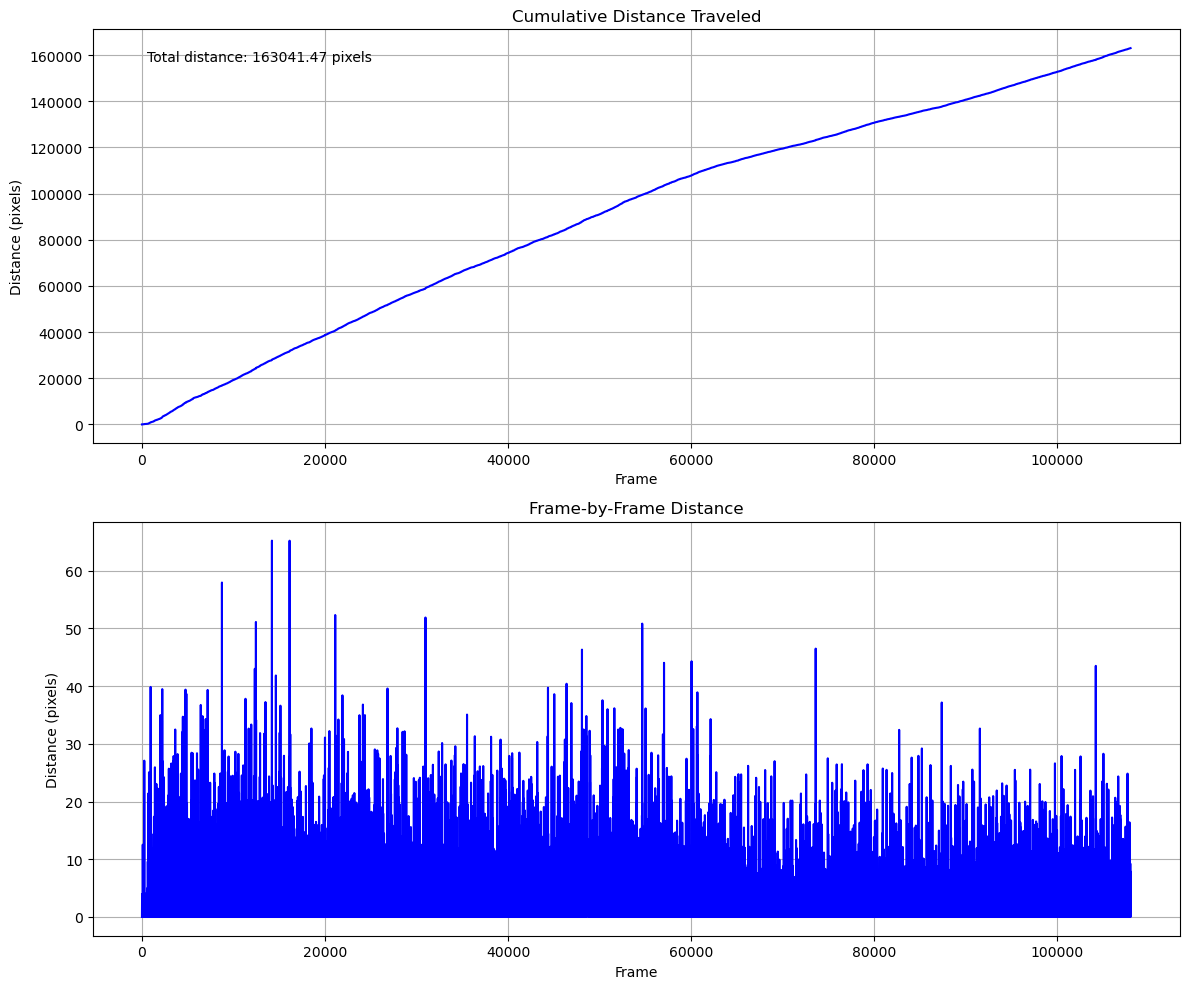

Distance keys found: ['snout_to_Left_distance', 'snout_to_Right_distance', 'snout_to_Inlet_distance', 'snout_to_Outlet_distance', 'snout_to_H2O_distance', 'snout_to_empty_distance']
Plotting snout_to_Left_distance with shape (107993,)
Plotting snout_to_Right_distance with shape (107993,)
Plotting snout_to_Inlet_distance with shape (107993,)
Plotting snout_to_Outlet_distance with shape (107993,)
Plotting snout_to_H2O_distance with shape (107993,)
Plotting snout_to_empty_distance with shape (107993,)
Plot saved to snout_distance_to_ports_plot.png


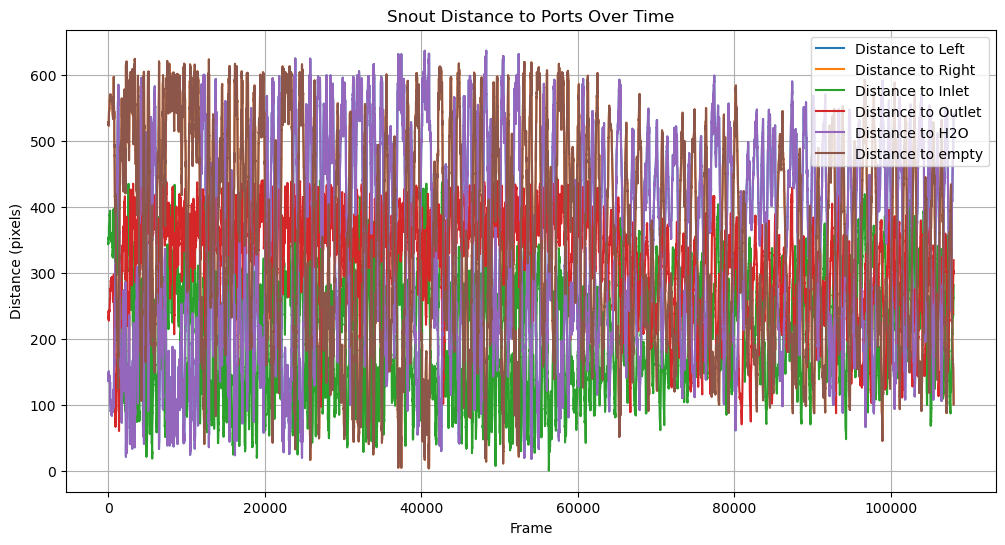

Plotting data for snout
Locations shape: (107993, 2, 1), Velocity shapes: x=(107993,), y=(107993,), mag=(107993,)
Plot saved to snout_position_and_velocity_plot_default_scale.png


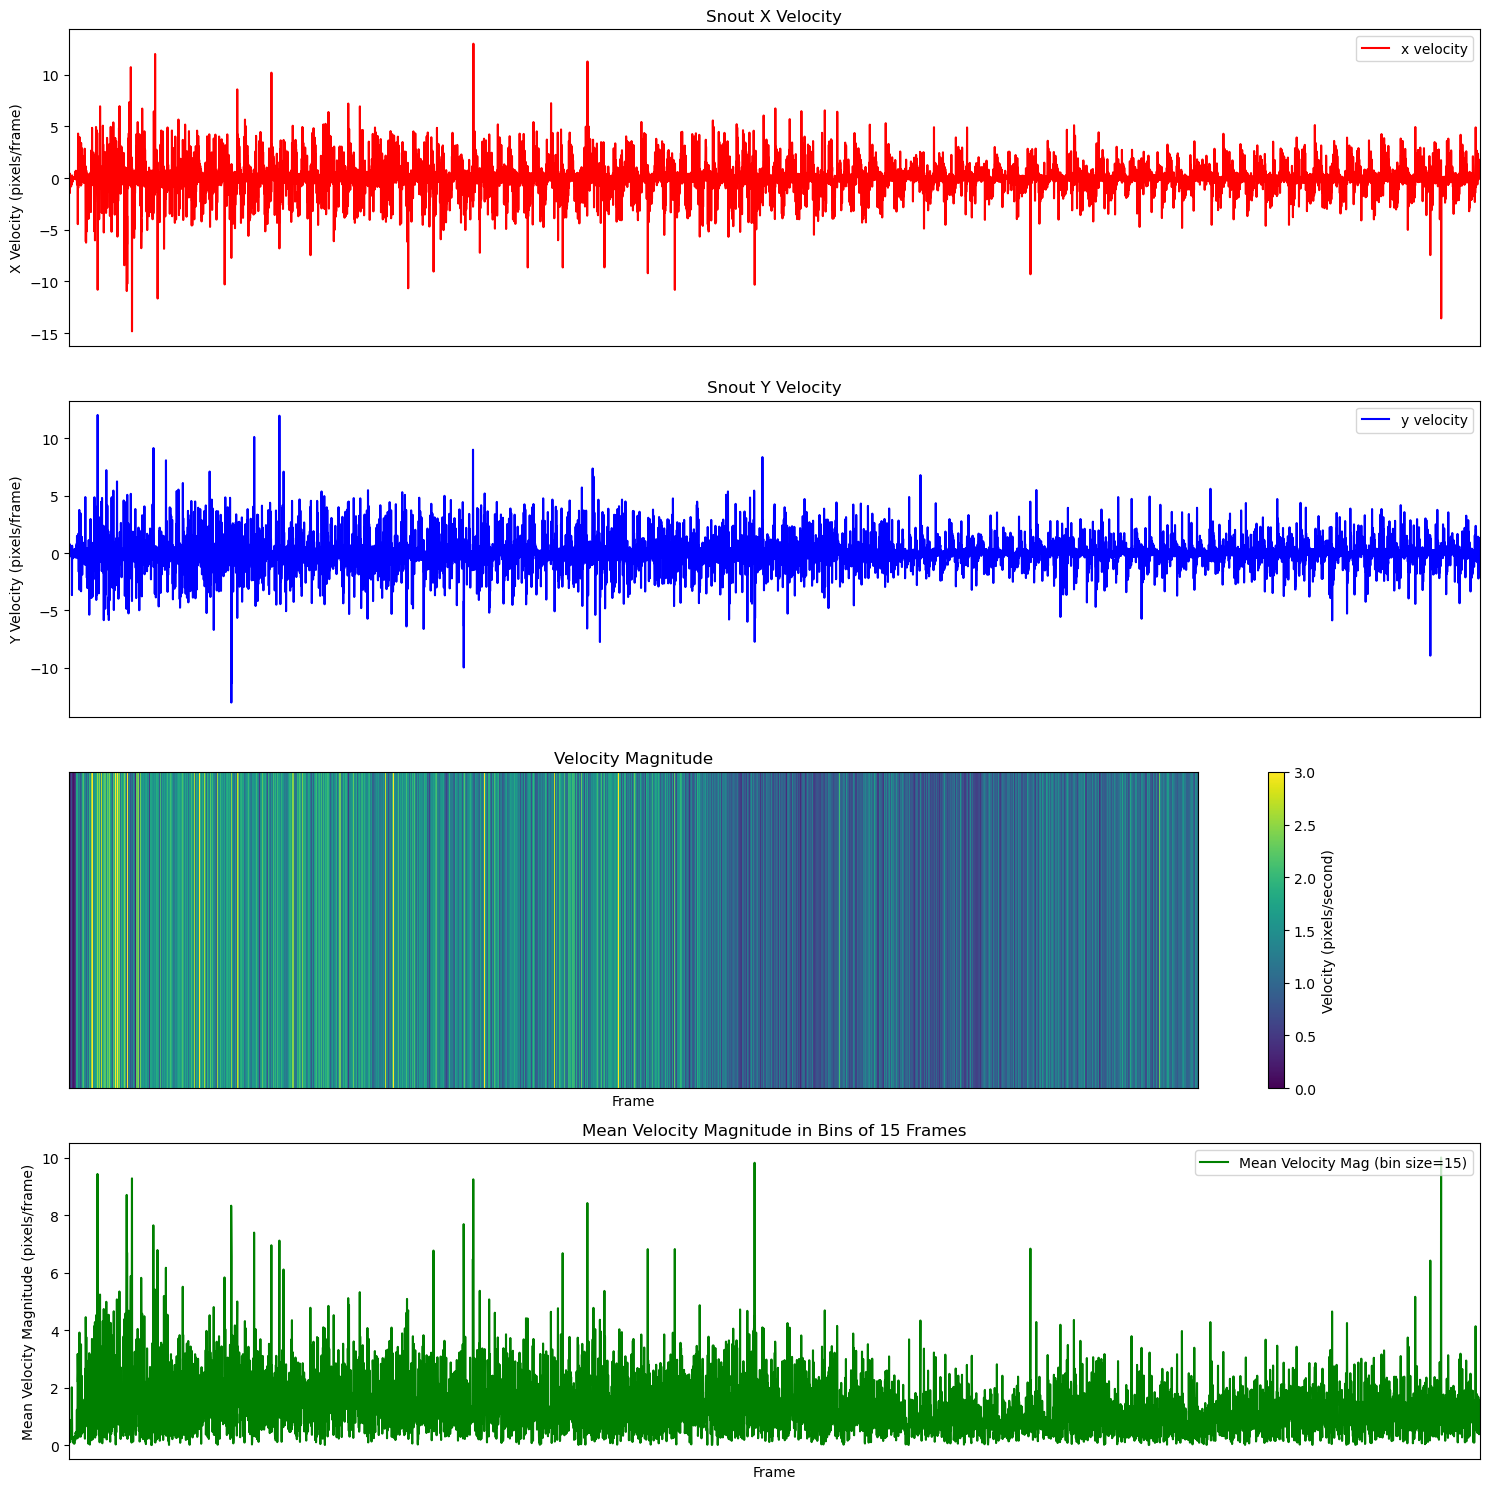

In [142]:
# Example usage
if __name__ == "__main__":
    file_path = Path("out.npz")
    load_and_plot_free_swimming(file_path)

In [146]:
plt.close('all')

# OLD FUNCTIONS/USEABLE LATER?

In [61]:
with h5py.File(configs_and_videos[0].sleap_path, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(configs_and_videos[0])
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
VideoConfig(video_path=/home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0001/20240718_sub-0001_OnePortEtohExperiment/20240718_sub-0001_OnePortEtohExperiment.mp4, config_path=/home/jmdelahanty/OneDrive/lgfl/rawdata/sub-0001/20240718_sub-0001_OnePortEtohExperiment/20240718_sub-0001_OnePortEtohExperiment.h5, syringe_contents={'left': 'H2O', 'right': 'empty'})

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(107993, 2, 2, 1)

===nodes===
0: snout
1: body



In [52]:
# def calculate_velocity(tracks: np.ndarray, node_index: int, fps: float = 30.0) -> Tuple[np.ndarray, np.ndarray]:
#     """
#     Calculate the instantaneous and smoothed velocity of a specific node over time.

#     Args:
#     tracks (np.ndarray): The SLEAP tracks data.
#     node_index (int): The index of the node to track.
#     fps (float): Frames per second of the video.

#     Returns:
#     Tuple[np.ndarray, np.ndarray]: Arrays of instantaneous and smoothed velocities for each frame.
#     """
#     # Extract the positions of the specified node
#     node_positions = tracks[:, node_index, :, 0]  # Shape: (frames, 2)

#     # Calculate the displacement between consecutive frames
#     displacements = np.diff(node_positions, axis=0)

#     # Calculate the distance moved in each frame
#     distances = np.linalg.norm(displacements, axis=1)

#     # Calculate instantaneous velocity (distance / time)
#     time_step = 1 / fps
#     instantaneous_velocity = distances / time_step

#     # Add a zero at the beginning for the initial velocity
#     instantaneous_velocity = np.insert(instantaneous_velocity, 0, 0)

#     # Calculate smoothed velocity using a moving average
#     window_size = int(fps)  # Use a 1-second window for smoothing
#     smoothed_velocity = np.convolve(instantaneous_velocity, np.ones(window_size)/window_size, mode='same')

#     return instantaneous_velocity, smoothed_velocity